In [ ]:
!pip install pytorch_msssim

In [ ]:
from google.colab import drive
import glob
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision                                           # High-level computer vision utilities and pretrained models
from torchvision import transforms, models                   # Transformations for image preprocessing and model zoo
from pytorch_msssim import ssim

from sklearn.decomposition import PCA
from matplotlib.colors import BoundaryNorm

import umap.umap_ as umap


import cv2
from skimage.registration import phase_cross_correlation
from skimage.io import imsave
from scipy.ndimage import fourier_shift
import copy

from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Polygon

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # For more reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Seed set to {seed}")

## Complete Data

In [ ]:
#SETUP AND PATHS
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully.")

# Define the base paths
BASE_PATH = '/content/drive/MyDrive/DS_ML_MFFF/zfish'

FIG_DIR = Path(BASE_PATH) / "figures"
FIG_DIR.mkdir(exist_ok=True)
print("Figures will be saved in:", FIG_DIR)

# Define all image and mask directories
TRAIN_MASK_IMG_DIR = Path(BASE_PATH) / 'train' / 'masked_images'
TEST_MASK_IMG_DIR = Path(BASE_PATH) / 'test' / 'masked_images'
print(f"\nTraining Images Path: {TRAIN_MASK_IMG_DIR}")
print(f"\nTraining Images Path: {TEST_MASK_IMG_DIR}")

if TRAIN_MASK_IMG_DIR.is_dir(): # Updated check for Path object
    print("Path exists and is ready.")
else:
    print("!!! ERROR: Path not found. Please check your folder structure on Drive.")

if TEST_MASK_IMG_DIR.is_dir(): # Updated check for Path object
    print("Path exists and is ready.")
else:
    print("!!! ERROR: Path not found. Please check your folder structure on Drive.")

files_train = sorted(list(TRAIN_MASK_IMG_DIR.glob("*.tif")))
files_test = sorted(list(TEST_MASK_IMG_DIR.glob("*.tif")))

#print(f"Total original training files: {len(all_train_files)}")
print(f"Using {len(files_train)} training files for the analysis.")

#print(f"Total original test files: {len(all_test_files)}")
print(f"Using {len(files_test)} test files for the analysis.")

Mounting Google Drive...
Mounted at /content/drive
Drive mounted successfully.
Figures will be saved in: /content/drive/MyDrive/DS_ML_MFFF/zfish/figures

Training Images Path: /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images

Training Images Path: /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images
Path exists and is ready.
Path exists and is ready.
Using 39 training files for the analysis.
Using 12 test files for the analysis.


In [ ]:
# Load Stacks

stacks_train = []
embryo_ids_train = []
lengths_train = []

print("\nLoading stacks...")
for p in files_train:
    arr_train = tiff.imread(str(p)).astype(np.float32) # shape: (T_i, H, W)

    stacks_train.append(arr_train)
    embryo_ids_train.append(p.stem)
    lengths_train.append(arr_train.shape[0])

total_frames_train= sum(lengths_train)
print("Total frames across all stacks:", total_frames_train)

# Metadata per frame (embryo_id, frame index)
frame_embryo_train = np.concatenate([[eid] * L for eid, L in zip(embryo_ids_train, lengths_train)])
frame_idx_train = np.concatenate([np.arange(L) for L in lengths_train])

dfmeta_train = pd.DataFrame({
    "embryo_id": frame_embryo_train,
    "frame_idx": frame_idx_train
})
print("\nMetadata DataFrame Head and Shape:")
print(dfmeta_train.head())
print(dfmeta_train.shape)


Loading stacks...
Total frames across all stacks: 17550

Metadata DataFrame Head and Shape:
                   embryo_id  frame_idx
0  masked_Acq_Bmp_tra_E1005o          0
1  masked_Acq_Bmp_tra_E1005o          1
2  masked_Acq_Bmp_tra_E1005o          2
3  masked_Acq_Bmp_tra_E1005o          3
4  masked_Acq_Bmp_tra_E1005o          4
(17550, 2)


In [ ]:
# Load Stacks for test

stacks_test = []
embryo_ids_test= []
lengths_test = []

print("\nLoading stacks...")
for p in files_test:
    arr_test = tiff.imread(str(p)).astype(np.float32) # shape: (T_i, H, W)

    stacks_test.append(arr_test)
    embryo_ids_test.append(p.stem)
    lengths_test.append(arr_test.shape[0])

total_frames_test= sum(lengths_test)
print("Total frames across all stacks:", total_frames_test)

# Metadata per frame (embryo_id, frame index)
frame_embryo_test = np.concatenate([[eid] * L for eid, L in zip(embryo_ids_test, lengths_test)])
frame_idx_test = np.concatenate([np.arange(L) for L in lengths_test])

dfmeta_test= pd.DataFrame({
    "embryo_id": frame_embryo_test,
    "frame_idx": frame_idx_test
})
print("\nMetadata DataFrame Head and Shape:")
print(dfmeta_test.head())
print(dfmeta_test.shape)


Loading stacks...
Total frames across all stacks: 5400

Metadata DataFrame Head and Shape:
                   embryo_id  frame_idx
0  masked_Acq_Bmp_tes_E1005o          0
1  masked_Acq_Bmp_tes_E1005o          1
2  masked_Acq_Bmp_tes_E1005o          2
3  masked_Acq_Bmp_tes_E1005o          3
4  masked_Acq_Bmp_tes_E1005o          4
(5400, 2)


In [ ]:
class AEDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform
        self.index = []

        print("Pre-calculating frame indices (reading file metadata)...")

        for stack_idx, path in enumerate(self.file_paths):
            try:

                with tiff.TiffFile(str(path)) as tif:
                    # 2. Get the number of frames/pages in the current TIFF file
                    T = len(tif.pages)

                # Build the index list (stack_idx, frame_idx)
                for t in range(T):
                    self.index.append((stack_idx, t))
            except Exception as e:
                # The FileNotFoundError occurs here if the file path is bad
                print(f"!!! CRITICAL ERROR: {path}")
                print(f"!!! Python Error: {e}")

        # Initialize cache
        self._stack_cache = {}
        self._max_cache_size = 5
    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        # 1. Get the path and frame index
        stack_idx, t = self.index[idx]
        file_path = self.file_paths[stack_idx]

        if stack_idx not in self._stack_cache:

            current_stack = tiff.imread(str(file_path)).astype(np.float32)

            # Update cache
            self._stack_cache[stack_idx] = current_stack
            if len(self._stack_cache) > self._max_cache_size:
                # Remove the oldest stack
                oldest_key = next(iter(self._stack_cache))
                del self._stack_cache[oldest_key]
        else:
            current_stack = self._stack_cache[stack_idx]

        # 4. Extract the single frame
        img = current_stack[t] # (H, W)

        # 5. Apply your normalization (as you had it)
        img -= img.min()
        if img.max() > 0:
            img = img / img.max()

        # Add channel dimension -> (1, H, W)
        if img.ndim == 2:
            img = img[None, :, :] # (1, H, W)

        image = torch.from_numpy(img)

        # Apply transform
        if self.transform:
            image = self.transform(image)

        return image.float(), image.float()

In [ ]:
set_seed(42)

Seed set to 42


In [ ]:
# Data augmentation + preprocessing for training

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),              # Random horizontal flip: Increases symmetry: retinas are often symmetric
    transforms.RandomRotation(degrees=180),               # Random rotation: Simulates head tilt, camera rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  #Color Jitter simulates variation across devices
    #transforms.RandomAffine(degrees=10, translate=(0.05,0.005)),
    # No ToTensor here: AEDataset already returns a torch tensor
])

# For val/test we do not need augmentation
val_transform = None
test_transform = None

In [ ]:
#Base dataset (no transform) to define indices
base_dataset = AEDataset(file_paths=files_train, transform=None)
num_frames = len(base_dataset)
print("Total frames in base dataset:", num_frames)

Pre-calculating frame indices (reading file metadata)...
Total frames in base dataset: 17550


In [ ]:
#Train/Val split indices (80/20 split)
train_size = int(0.8 * num_frames)
val_size = num_frames - train_size

indices = torch.randperm(num_frames).tolist()
train_indices = indices[:train_size]
val_indices   = indices[train_size:]


# Datasets with and without transform
# Train dataset with augmentation
train_dataset = AEDataset(file_paths=files_train, transform=train_transform)

# Validation dataset without augmentation
val_dataset   = AEDataset(file_paths=files_train, transform=val_transform)

# Subsets using the same indices
train_ds1 = Subset(train_dataset, train_indices)
val_ds1   = Subset(val_dataset,   val_indices)

batch_size = 16

train_loader = DataLoader(train_ds1, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds1, batch_size=batch_size, shuffle=False)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))


#Test dataset and loader (no augmentation)
test_dataset = AEDataset(file_paths=files_test, transform=test_transform)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Test dataset length (frames):", len(test_dataset))
print("Train batches:", len(test_loader))

Pre-calculating frame indices (reading file metadata)...
Pre-calculating frame indices (reading file metadata)...
Train batches: 878 Val batches: 220
Pre-calculating frame indices (reading file metadata)...
Test dataset length (frames): 5400
Train batches: 338


In [ ]:
save_path = "/content/drive/MyDrive/DS_ML_MFFF/zfish"
os.makedirs(save_path, exist_ok=True)

In [ ]:
def plot_data_batch(loader, title, num_images=4):
    """
    Plots the first few images from a single batch of a PyTorch DataLoader
    and displays the plot directly in the notebook.
    """
    # Get one batch
    input_batch, target_batch = next(iter(loader))

    # Detach from GPU (if applicable) and convert to numpy
    input_images = input_batch.cpu().numpy()

    # Determine plot dimensions
    num_to_plot = min(num_images, input_images.shape[0])

    # Assuming single-channel images (1, H, W) -> (H, W) for plotting
    if input_images.shape[1] == 1:
        input_images = input_images[:, 0, :, :]

    # Create the figure and axes
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)

    if num_to_plot == 1:
        axes = [axes]

    for i in range(num_to_plot):
        ax = axes[i]
        # Use vmin/vmax based on the expected [0, 1] normalization range
        ax.imshow(input_images[i], cmap='gray', vmin=0.0, vmax=1.0)
        ax.set_title(f"Frame {i+1}", fontsize=10)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # EXPORT
    filename = f"{title.replace(' ', '_').lower()}.svg"
    export_path = os.path.join(save_path, filename)
    plt.savefig(export_path, format='svg', bbox_inches='tight')

    plt.show()

    return export_path

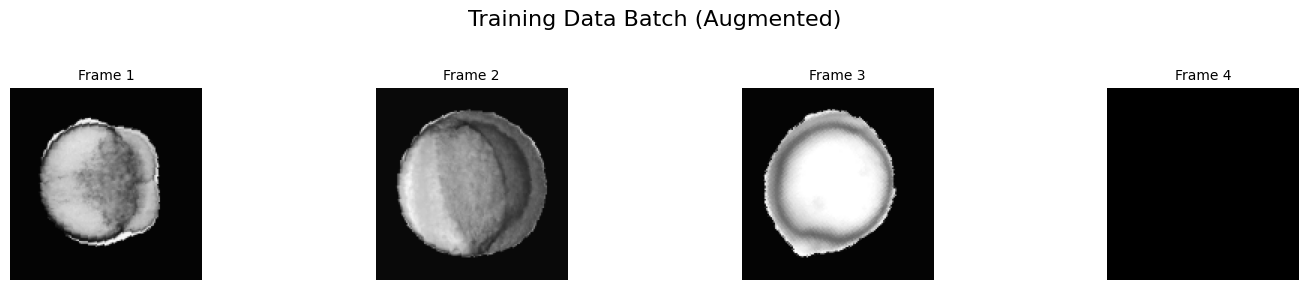

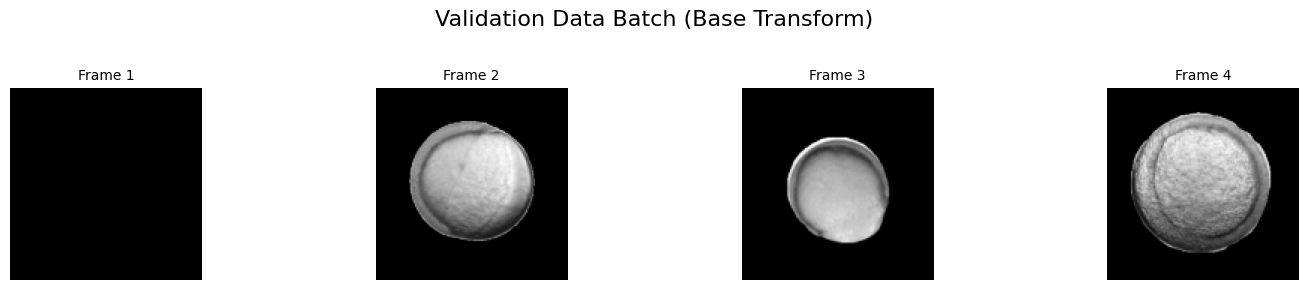

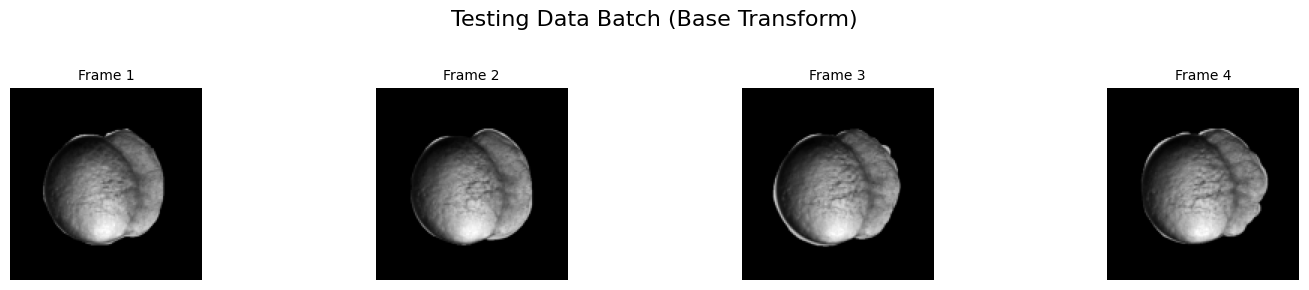

In [ ]:
# Plot Training Batch
train_filename = plot_data_batch(train_loader, "Training Data Batch (Augmented)")

# Plot Validation Batch
val_filename = plot_data_batch(val_loader, "Validation Data Batch (Base Transform)")

# Plot Testing Batch
test_filename = plot_data_batch(test_loader, "Testing Data Batch (Base Transform)")

In [ ]:
class AutoEncoder_nosup(nn.Module):
    def __init__(self, latent_dim=128, input_size=128):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        # compute encoder output shape
        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_size, input_size)
            h = self.encoder(dummy)
        self.enc_out_shape = h.shape[1:]           # (C, H, W)
        enc_out_dim = h.numel()                    # C * H * W

        self.flatten = nn.Flatten()
        self.fc_latent = nn.Linear(enc_out_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, enc_out_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = self.flatten(h)
        z = self.fc_latent(h)
        return z

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, *self.enc_out_shape)
        x_hat = self.decoder(h)
        return x_hat

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128

model1 = AutoEncoder_nosup(latent_dim=latent_dim).to(device)

optimizer = torch.optim.Adam(model1.parameters(), lr=1e-5)

#Loss Functions
criterion_mse = nn.MSELoss()

def ssim_loss(x,y):
    return 1-ssim(x,y,data_range=1.0)

def combined_loss(x_hat, x, alpha=0.1):
    mse=criterion_mse(x_hat, x)
    ssim_1=ssim_loss(x_hat, x)
    return alpha * mse + (1-alpha) * ssim_1


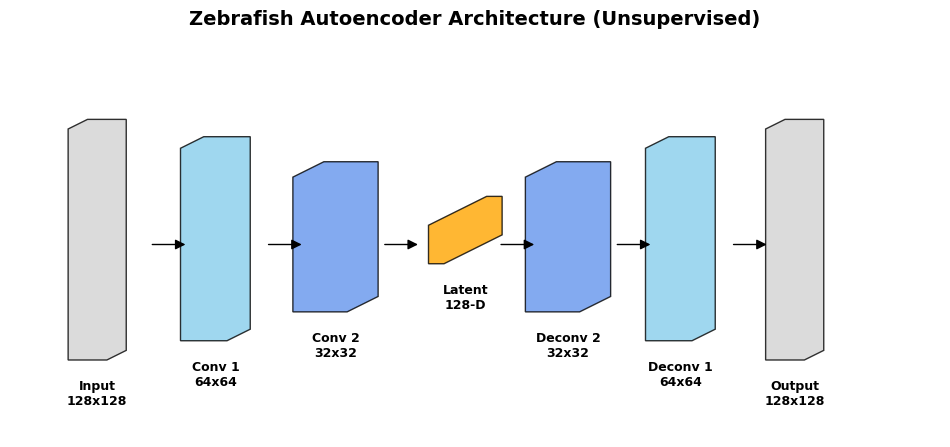

In [ ]:
def draw_volume(ax, center_x, center_y, width, height, depth, label, color="skyblue"):
    """Draws a 3D-looking box (trapezoid/parallelogram) to represent a layer."""
    # Vertices for the front face
    dx = depth * 0.5
    dy = depth * 0.5

    # Simple polygon to represent the front face of the 'volume'
    # We use a trapezoidal shape to mimic perspective
    pts = [
        (center_x - width/2, center_y - height/2),
        (center_x + width/2, center_y - height/2),
        (center_x + width/2 + dx, center_y - height/2 + dy),
        (center_x + width/2 + dx, center_y + height/2 + dy),
        (center_x - width/2 + dx, center_y + height/2 + dy),
        (center_x - width/2, center_y + height/2),
    ]

    poly = Polygon(pts, closed=True, facecolor=color, edgecolor='black', alpha=0.8, linewidth=1)
    ax.add_patch(poly)

    # Label at the bottom
    ax.text(center_x + dx/2, center_y - height/2 - 0.05, label,
            ha='center', va='top', fontsize=9, fontweight='bold')

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1)
ax.set_axis_off()

# Define layers: (x, width, height, depth, label, color)
# The height decreases toward the latent space (hourglass)
layers = [
    (0.1, 0.05, 0.6, 0.05, "Input\n128x128", "lightgray"),
    (0.25, 0.06, 0.5, 0.06, "Conv 1\n64x64", "skyblue"),
    (0.4, 0.07, 0.35, 0.08, "Conv 2\n32x32", "cornflowerblue"),
    (0.55, 0.02, 0.1, 0.15, f"Latent\n{latent_dim}-D", "orange"),
    (0.7, 0.07, 0.35, 0.08, "Deconv 2\n32x32", "cornflowerblue"),
    (0.85, 0.06, 0.5, 0.06, "Deconv 1\n64x64", "skyblue"),
    (1.0, 0.05, 0.6, 0.05, "Output\n128x128", "lightgray")
]

# Draw volumes
for x, w, h, d, lbl, col in layers:
    draw_volume(ax, x, 0.5, w, h, d, lbl, color=col)

# Draw arrows between them
for i in range(len(layers) - 1):
    x1 = layers[i][0] + 0.08
    x2 = layers[i+1][0] - 0.02
    arrow = FancyArrowPatch((x1, 0.5), (x2, 0.5),
                             arrowstyle='-|>', mutation_scale=15,
                             linewidth=1, color='black')
    ax.add_patch(arrow)

plt.title("Zebrafish Autoencoder Architecture (Unsupervised)", fontsize=14, fontweight='bold', pad=20)

# Export as SVG
filename = "autoencoder_architecture_3D.svg"
plt.savefig(os.path.join(save_path, filename), format='svg', bbox_inches='tight')

plt.show()

In [ ]:
def train_ae_nosup(model1, train_loader1, val_loader1, optimizer, device,
                   epochs=200, patience=5, save_path="best_ae.pth"):
    model1.to(device)
    history1 = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        # TRAIN
        model1.train()
        train_loss = 0.0
        for noisy, clean in train_loader1:
            noisy = noisy.to(device)
            clean = clean.to(device)

            optimizer.zero_grad()
            output = model1(noisy)
            loss = ssim_loss(output, clean)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * noisy.size(0)

        train_loss /= len(train_loader1.dataset)

        # VALIDATION
        model1.eval()
        val_loss = 0.0
        with torch.no_grad():
            for noisy, clean in val_loader1:
                noisy = noisy.to(device)
                clean = clean.to(device)
                output = model1(noisy)
                loss = ssim_loss(output, clean)
                val_loss += loss.item() * noisy.size(0)

        val_loss /= len(val_loader1.dataset)

        history1['train_loss'].append(train_loss)
        history1['val_loss'].append(val_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # EARLY STOPPING + SAVE BEST MODEL
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            # SAVE BEST WEIGHTS
            torch.save(model1.state_dict(), save_path)
            print(f"  → New best model saved to {save_path}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    return history1

In [ ]:
#best_model_path = "best_ae_zfish.pth"
#history1 = train_ae_nosup(model1, train_loader, val_loader, optimizer, device, epochs=100, patience=5,
                          #save_path=best_model_path)

KeyboardInterrupt: 

In [ ]:

#!cp best_ae_zfish.pth /content/drive/MyDrive/DS_ML_MFFF/zfish/

In [ ]:
latent_dim = 128   # <-- MUST match the model you trained

model_loaded = AutoEncoder_nosup(latent_dim=latent_dim).to(device)

In [ ]:
best_model_path = "/content/drive/MyDrive/DS_ML_MFFF/zfish/best_ae_zfish.pth"

state_dict = torch.load(best_model_path, map_location=device)
model_loaded.load_state_dict(state_dict)
model_loaded.eval()

print("Model successfully loaded!")

Model successfully loaded!
